In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression,ridge_regression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


In [3]:
givenTrain = pd.read_csv("../input/train.csv",parse_dates = ['Date'])
givenTest = pd.read_csv("../input/test.csv",parse_dates = ['Date'])
givenStore = pd.read_csv("../input/store.csv")

IOError: File ../input/train.csv does not exist

In [4]:
givenTrain[givenTrain.StateHoliday=="0"] = 0 

In [5]:
givenTrain.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [6]:
givenStore.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

**Checking Data Sanity: 
    Making sure no erroneos value exist.**

In [7]:
givenTrain[(givenTrain['Open'] == 0) & (givenTrain['Sales'] != 0)]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


**For this analysis, only Stores that are open are considered.**

In [8]:
openStores = givenTrain[givenTrain['Open'] == 1]


**Categorical values are converted to numerical values for analysis.**

In [9]:
openStores.drop(columns='Date',axis=1,inplace =True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
openStores = pd.get_dummies(openStores)
storeData = pd.get_dummies(givenStore)

**Merging training and store data**

In [12]:
mergeData = pd.merge(openStores, storeData, how="inner")

**Handling Null Values **

In [13]:
mergeData.isna().sum()

Store                                 0
DayOfWeek                             0
Sales                                 0
Customers                             0
Open                                  0
Promo                                 0
SchoolHoliday                         0
StateHoliday_0                        0
StateHoliday_a                        0
StateHoliday_b                        0
StateHoliday_c                        0
CompetitionDistance                 273
CompetitionOpenSinceMonth         36157
CompetitionOpenSinceYear          36157
Promo2                                0
Promo2SinceWeek                   59277
Promo2SinceYear                   59277
StoreType_a                           0
StoreType_b                           0
StoreType_c                           0
StoreType_d                           0
Assortment_a                          0
Assortment_b                          0
Assortment_c                          0
PromoInterval_Feb,May,Aug,Nov         0


**Varaibles related to Competition are dropped and Promo2SinceWeek, Promo2SinceYear are dropped for now.**

In [14]:
cleanData= mergeData.drop(mergeData[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear']],axis= 1)

In [15]:
cleanData.isna().sum()

Store                             0
DayOfWeek                         0
Sales                             0
Customers                         0
Open                              0
Promo                             0
SchoolHoliday                     0
StateHoliday_0                    0
StateHoliday_a                    0
StateHoliday_b                    0
StateHoliday_c                    0
Promo2                            0
StoreType_a                       0
StoreType_b                       0
StoreType_c                       0
StoreType_d                       0
Assortment_a                      0
Assortment_b                      0
Assortment_c                      0
PromoInterval_Feb,May,Aug,Nov     0
PromoInterval_Jan,Apr,Jul,Oct     0
PromoInterval_Mar,Jun,Sept,Dec    0
dtype: int64

In [16]:
X = cleanData.drop(cleanData[['Sales', 'Store','Open']],axis = 1) # Store and Open have no explanatory power and sales is the target variable.
y = cleanData['Sales'] 

**Feature Selection:**

 Correlated variables are checked using a heat map shown below.
 
 Based on the results (highly correlated positive as well negative), certain variables are removed from the model.


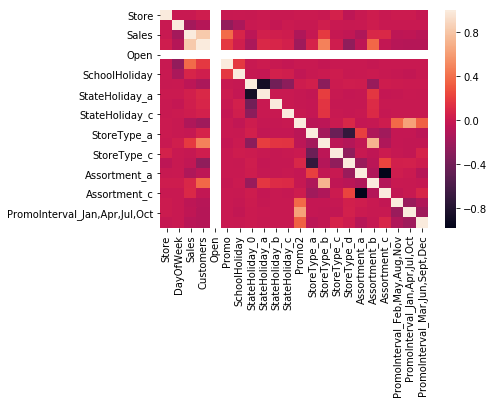

In [17]:
corr = cleanData.corr()
sns.heatmap(corr)

From the correlation plot, its evident that 'assortment_a' and 'assortment_c' are correlated.

Also following variables
'store_type c' and 'store_type a' are correlated

'StateHoliday _a' and 'StateHoliday_0' 

In [18]:
X1 = cleanData.drop(cleanData[['Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
y = cleanData['Sales']

In [19]:
X2 = sm.add_constant(X1)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                 3.670e+04
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        03:41:23   Log-Likelihood:            -9.6379e+05
No. Observations:              113050   AIC:                         1.928e+06
Df Residuals:                  113034   BIC:                         1.928e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [20]:
def unRestrictedModel(cleanData):
    predictiveVariables = cleanData.drop(cleanData[['Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
    toPredict = cleanData['Sales']
    X_train, X_test, y_train, y_test = train_test_split(predictiveVariables, toPredict, test_size=0.33, random_state=42)
    lm = LinearRegression()
    lfit = lm.fit(X_train,y_train)
    yPredict = lfit.predict(X_test)
    return np.sqrt(mean_absolute_error(y_test,yPredict))
#unRestrictedModel(cleanData)
    

In [21]:
def RestrictedModel(cleanData): #Dropping promo
    predictiveVariables = cleanData.drop(cleanData[['Promo','Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
    toPredict = cleanData['Sales']
    X_train, X_test, y_train, y_test = train_test_split(predictiveVariables, toPredict, test_size=0.33, random_state=42)
    lm = LinearRegression()
    lfit = lm.fit(X_train,y_train)
    yPredict = lfit.predict(X_test)
    return np.sqrt(mean_absolute_error(y_test,yPredict))
#RestrictedModel(cleanData)

In [22]:
randomNess = 0
for i in range(1,101):
    f=(i/100)
    df =cleanData.sample(frac = f ,replace=True)
    errorFullModel = unRestrictedModel(df)
    errorNonPromoModel = RestrictedModel(df)
    if errorFullModel > errorNonPromoModel:
        randomNess = randomNess + 1
le= len(cleanData)
print(randomNess)
pVal = randomNess/100
pVal

0


0.0

**Intrepretation**:
  
   Bootstrapping the given data for about 100 times,  the model with promos fits the data better than the model without promos.(As it is evident from p value)
   
   



**Supporting the above claim with other regressors**:

Checking if Mean Absolute Error changes with respect to the presence of Promo

In [23]:
# Gradient Boosting Regressor with promos included in explanatory variables
X = cleanData.drop(cleanData[['Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
Y = cleanData['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.02, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
mae = mean_absolute_error(y_test, clf.predict(X_test))
print("Mean Absolute Error with Promos included: %.4f" % mae)

# Gradient Boosting Regressor after removing promos in explanatory variables
X = cleanData.drop(cleanData[['Promo','Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
Y = cleanData['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.02, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
mae = mean_absolute_error(y_test, clf.predict(X_test))
print("Mean Absolute Error without Promos included: %.4f" % mae)

Mean Absolute Error with Promos included: 787.5329
Mean Absolute Error without Promos included: 903.8035


In [28]:
rf = RandomForestRegressor(n_estimators=100)
X = cleanData.drop(cleanData[['Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
Y = cleanData['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
rf.fit(X,y)
mae = mean_absolute_error(y_test, rf.predict(X_test))
print("MAE with Promos included: %.4f" % mae)

rf1 = RandomForestRegressor(n_estimators=100)
X = cleanData.drop(cleanData[['Promo','Sales', 'Store','Open','PromoInterval_Feb,May,Aug,Nov','StoreType_a','Assortment_a','StateHoliday_a']],axis = 1)
Y = cleanData['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
rf1.fit(X,y)
mae1 = mean_absolute_error(y_test, rf1.predict(X_test))
print("MAE without Promos included: %.4f" % mae1)

MAE with Promos included: 414.4766
MAE without Promos included: 522.6829


**Conclusion: **

From the above results, one can conclude that the variable 'Promo' has significance in explaining the sales of Rossmann Data.